In [1]:
pip install -U "jax[tpu]"

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import jax.lax as lax
import time
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
device = jax.devices()[0]
print("Device kind:", device.device_kind)
print("Device:", device)

Device kind: TPU v2
Device: TPU_0(process=0,(0,0,0,0))


In [4]:
def gelu_jax(x):
    return 0.5 * x * (1 + jnp.tanh(jnp.sqrt(2 / jnp.pi) * (x + 0.044715 * x**3)))


def lnorm_jax(x, eps=1e-5):
    mean = jnp.mean(x, axis=0, keepdims=True)
    var = jnp.var(x, axis=0, keepdims=True)
    return (x - mean) / jnp.sqrt(var + eps)

def softmax_jax(x, axis=-1):

    x_max = jnp.max(x, axis=axis, keepdims=True)
    e_x = jnp.exp(x - x_max)
    return e_x / jnp.sum(e_x, axis=axis, keepdims=True)

def matmul_jax(a, b):
    a_i32 = a.astype(jnp.int32)
    b_i32 = b.astype(jnp.int32)
    result = a_i32 @ b_i32
    return jnp.clip(result, -128, 127).astype(jnp.int8)

def attention_per_head_jax(K, Q, V, l, ddh, b, h):
    lb = l*b
    E2 = jnp.zeros((K.shape[0], lb), dtype=jnp.int32)

    def process_single_head(E2, idx):
        j, i = idx // h, idx % h
        indJ = j*l
        indI2 = i*ddh


        K_slice = lax.dynamic_slice(K, (indI2, indJ), (ddh, l)).astype(jnp.int32)
        Q_slice = lax.dynamic_slice(Q, (indI2, indJ), (ddh, l)).astype(jnp.int32)
        E1 = K_slice.T @ Q_slice

        V_slice = lax.dynamic_slice(V, (indI2, indJ), (ddh, l)).astype(jnp.int32)

        scores = K_slice.T @ Q_slice / jnp.sqrt(ddh)
        E1 = softmax_jax(scores, axis=0)

        result = V_slice @ E1


        result_int8 = jnp.clip(result, -128, 127).astype(jnp.int8)
        E2 = lax.dynamic_update_slice(E2, result_int8, (indI2, indJ))
        return E2, None

    E2_init = jnp.zeros((d, lb), dtype=jnp.int8)
    idxs = jnp.arange(b * h)
    idxs=jnp.arange(2)
    E2, _ = lax.scan(process_single_head, E2_init, idxs)

    return E2

def mha_output_jax(WO, E2, EI):
    WO_i32 = WO.astype(jnp.int32)
    E2_i32 = E2.astype(jnp.int32)
    EI_i32 = EI.astype(jnp.int32)
    AO = EI_i32 + WO_i32 @ E2_i32
    result = lnorm_jax(AO)
    return jnp.clip(result, -128, 127).astype(jnp.int8)

def ffn_forward_jax(W1, W2, AO):
    W1_i32 = W1.astype(jnp.int32)
    W2_i32 = W2.astype(jnp.int32)
    AO_i32 = AO.astype(jnp.int32)
    E3b = W1_i32 @ AO_i32
    E3 = gelu_jax(E3b)
    EOb = W2_i32 @ E3
    EO = lnorm_jax(EOb + AO_i32)
    return jnp.clip(EO, -128, 127).astype(jnp.int8)



b = 24
l = 128
d = 1024
h = 16

f = 4 * d
ddh = d // h
lb = b * l



In [5]:

from jax import random

key = jax.random.PRNGKey(0)
keys = jax.random.split(key, 7)



EI_jax = jax.random.randint(keys[0], (d, lb), minval=-128, maxval=128, dtype=jnp.int8)
WQ = jax.random.randint(keys[1], (d, d), minval=-128, maxval=128, dtype=jnp.int8)
WK = jax.random.randint(keys[2], (d, d), minval=-128, maxval=128, dtype=jnp.int8)
WV = jax.random.randint(keys[3], (d, d), minval=-128, maxval=128, dtype=jnp.int8)
WO = jax.random.randint(keys[4], (d, d), minval=-128, maxval=128, dtype=jnp.int8)
W1 = jax.random.randint(keys[5], (f, d), minval=-128, maxval=128, dtype=jnp.int8)
W2 = jax.random.randint(keys[6], (d, f), minval=-128, maxval=128, dtype=jnp.int8)



In [6]:
jax.config.update('jax_default_matmul_precision', 'highest')

In [7]:
jax.device_put(EI_jax).block_until_ready()
jax.device_put(WQ).block_until_ready()
jax.device_put(WK).block_until_ready()
jax.device_put(WV).block_until_ready()
jax.device_put(WO).block_until_ready()
jax.device_put(W1).block_until_ready()
jax.device_put(W2).block_until_ready()
results={}

In [8]:

# JAX WITHOUT JIT
results["JAX"] = {}


Qj = matmul_jax(WQ,  EI_jax).block_until_ready()
start = time.time()
Qj = matmul_jax(WQ,  EI_jax).block_until_ready()
end = time.time()
results["JAX"]["matmul_Q"] = end - start

start = time.time()
Kj = matmul_jax(WK,  EI_jax).block_until_ready()
end = time.time()
results["JAX"]["matmul_K"] = end - start

start = time.time()
Vj = matmul_jax(WV,  EI_jax).block_until_ready()
end = time.time()
results["JAX"]["matmul_V"] = end - start

start = time.time()
E2j = attention_per_head_jax(Kj, Qj, Vj, l, ddh, b, h).block_until_ready()
end = time.time()
results["JAX"]["attention"] = end - start

start = time.time()
AOj = mha_output_jax(WO, E2j, EI_jax).block_until_ready()
end = time.time()
results["JAX"]["mha_output"] = end - start

start = time.time()
EOj = ffn_forward_jax(W1, W2, AOj).block_until_ready()
end = time.time()
results["JAX"]["ffn"] = end - start

results["JAX"]["total"] = sum(results["JAX"].values())



In [9]:
results["JIT-COMP"] = {}

# JIT
matmul_qkv_jit = jax.jit(matmul_jax)
matmul_jit= jax.jit(matmul_jax)
attention_per_head_jit = jax.jit(attention_per_head_jax, static_argnums=(3, 4, 5, 6))
mha_output_jit = jax.jit(mha_output_jax)
ffn_forward_jit = jax.jit(ffn_forward_jax)


matmul_jit= jax.jit(matmul_jax)
start = time.time()
Qj = matmul_jit(WQ,  EI_jax).block_until_ready()
end = time.time()
results["JIT-COMP"]["matmul_Q"] = end - start

start = time.time()
Kj = matmul_jit(WK,  EI_jax).block_until_ready()
end = time.time()
results["JIT-COMP"]["matmul_K"] = end - start

start = time.time()
Vj = matmul_jit(WV,  EI_jax).block_until_ready()
end = time.time()
results["JIT-COMP"]["matmul_V"] = end - start



start_attention=  time.time()

E2j = attention_per_head_jit(Kj, Qj, Vj, l, ddh, b, h).block_until_ready()
end_attention = time.time()
t = end_attention - start_attention
results["JIT-COMP"]["attention"] = t


start_mha_output=  time.time()
AOj = mha_output_jit(WO, E2j, EI_jax).block_until_ready()
end_mha_output = time.time()
t= end_mha_output - start_mha_output
results["JIT-COMP"]["mha_output"] = t

start_ffn=time.time()
FFj = ffn_forward_jit(W1, W2, AOj).block_until_ready()
end_ffn = time.time()
t = end_ffn - start_ffn

results["JIT-COMP"]["ffn"] = t

results["JIT-COMP"]["total"] = sum(results["JIT-COMP"].values())


In [10]:
# JAX with JIT
results["JAX-JIT"] = {}
Qj = matmul_jit(WQ,  EI_jax).block_until_ready()
start = time.time()
Qj = matmul_jit(WQ,  EI_jax).block_until_ready()
end = time.time()
results["JAX-JIT"]["matmul_Q"] = end - start

start = time.time()
Kj = matmul_jit(WK,  EI_jax).block_until_ready()
end = time.time()
results["JAX-JIT"]["matmul_K"] = end - start

start = time.time()
Vj = matmul_jit(WV,  EI_jax).block_until_ready()
end = time.time()
results["JAX-JIT"]["matmul_V"] = end - start


start_attention=  time.time()

E2j = attention_per_head_jit(Kj, Qj, Vj, l, ddh, b, h).block_until_ready()
end_attention = time.time()
t = end_attention - start_attention
results["JAX-JIT"]["attention"] = t


start_mha_output=  time.time()
AOj = mha_output_jit(WO, E2j, EI_jax).block_until_ready()
end_mha_output = time.time()
t= end_mha_output - start_mha_output
results["JAX-JIT"]["mha_output"] = t


start_ffn=time.time()
FFj = ffn_forward_jit(W1, W2, AOj).block_until_ready()
end_ffn = time.time()
t = end_ffn - start_ffn
results["JAX-JIT"]["ffn"] = t

results["JAX-JIT"]["total"] = sum(results["JAX-JIT"].values())

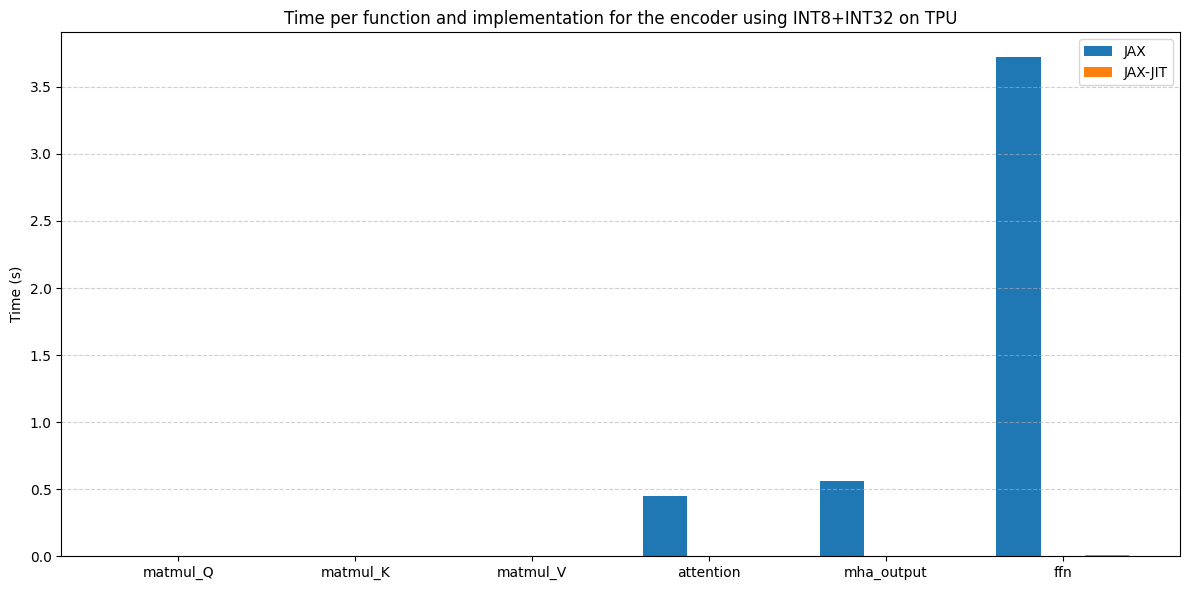

In [11]:


labels = ["matmul_Q","matmul_K","matmul_V", "attention", "mha_output", "ffn"]
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(x - width, [results["JAX"][l] for l in labels], width, label='JAX')
#ax.bar(x, [results["JIT-COMP"][l] for l in labels], width, label='JIT-COMP')
ax.bar(x  + width, [results["JAX-JIT"][l] for l in labels], width, label='JAX-JIT')

ax.set_ylabel('Time (s)')
ax.set_title('Time per function and implementation for the encoder using INT8+INT32 on TPU')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

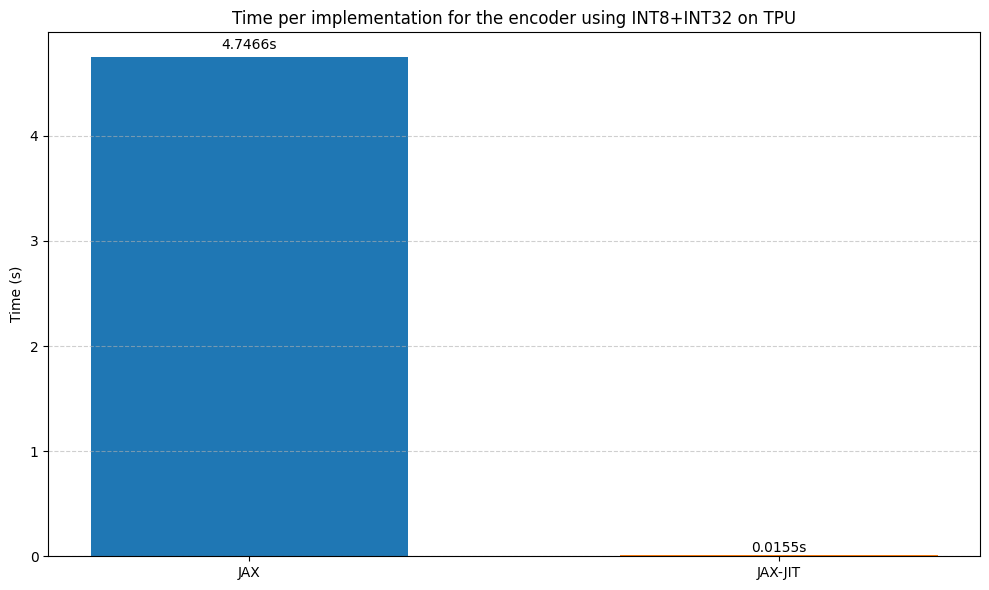

In [12]:

labels = [ "JAX","JAX-JIT"]
x = np.arange(len(labels))
width = 0.6
fig, ax = plt.subplots(figsize=(10, 6))


ax.bar(x, [results[label]["total"] for label in labels], width,
       color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])

for i, label in enumerate(labels):
    height = results[label]["total"]
    ax.text(i, height + 0.01 * height, f'{height:.4f}s',
            ha='center', va='bottom')

ax.set_ylabel('Time (s)')
ax.set_title('Time per implementation for the encoder using INT8+INT32 on TPU')
ax.set_xticks(x)
ax.set_xticklabels(labels)


ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()


plt.show()

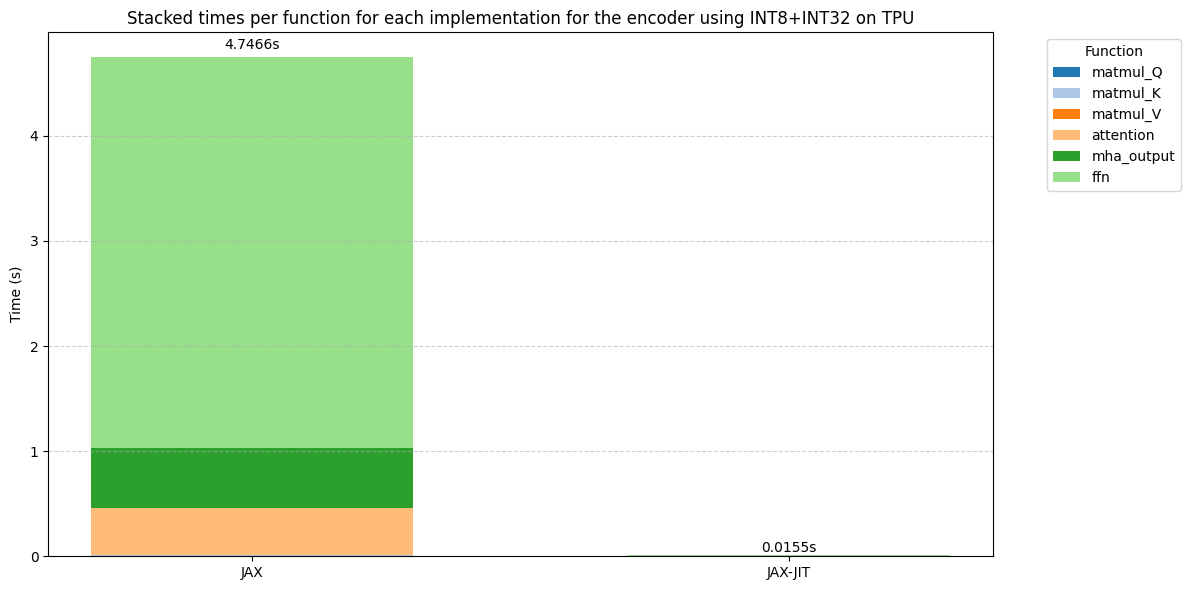

In [13]:

implementations = ["JAX", "JAX-JIT"]
functions = ["matmul_Q", "matmul_K", "matmul_V", "attention", "mha_output", "ffn"]
colors = plt.get_cmap("tab20").colors

x = np.arange(len(implementations))
width = 0.6

fig, ax = plt.subplots(figsize=(12, 6))


bottom = np.zeros(len(implementations))


for i, func in enumerate(functions):
    values = [results[impl][func] for impl in implementations]
    ax.bar(x, values, width, label=func, bottom=bottom, color=colors[i])
    bottom += values


for i, impl in enumerate(implementations):
    total = sum(results[impl][func] for func in functions)
    ax.text(i, total + 0.01 * total, f'{total:.4f}s', ha='center', va='bottom')

ax.set_ylabel('Time (s)')
ax.set_title('Stacked times per function for each implementation for the encoder using INT8+INT32 on TPU')
ax.set_xticks(x)
ax.set_xticklabels(implementations)


ax.legend(title="Function", bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()


In [14]:

df = pd.DataFrame(results).T


cols_orden = ["matmul_Q", "matmul_K", "matmul_V", "attention", "mha_output", "ffn", "total"]
df = df[cols_orden]


df




,matmul_Q,matmul_K,matmul_V,attention,mha_output,ffn,total
JAX,0.004249,0.004017,0.004057,0.449023,0.564020,3.721263,4.746629
JIT-COMP,0.725156,0.001149,0.001113,0.162230,0.904771,8.477676,10.272094
JAX-JIT,0.001281,0.001206,0.001234,0.000953,0.001384,0.009469,0.015527
